### LSTM Network 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm  import tqdm_notebook #used for loading bar (e.g. to visualise how long an operation is taking)

#read in data
import requests
import tarfile
import os
import zipfile
import regex as re #to clean the text
import string

In [2]:
def maybe_download(data_url, path):
    if os.path.exists(os.getcwd()+"/"+path):
        print("Data already present.")
    else:
        print("Downloading data...")
        r = requests.get(data_url, stream=True)
        file_name = data_url.split("/")[-1]
        with open(file_name,'wb') as f:
            total_length = int(r.headers.get('content-length'))
            for chunk in tqdm_notebook(r.iter_content(chunk_size=8192), total=(total_length//8192) + 1): 
                if chunk:
                    f.write(chunk)
                    f.flush()
        print("Extracting data")
        if "tar" in file_name:
            unzipper = tarfile.open(file_name)
        elif "zip" in file_name:
            unzipper = zipfile.ZipFile(file_name,"r")
        unzipper.extractall()
        unzipper.close()
        os.remove(path) 
        print("Success: Data downloaded and extracted.")

In [3]:
maybe_download(data_url="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", path="aclImdb")

Data already present.


In [4]:
maybe_download(data_url="http://nlp.stanford.edu/data/wordvecs/glove.6B.zip", path="glove.6B.50d.txt")

Data already present.


In [5]:
def get_GloVe_vecs(embedding_size):
    file_name = "glove.6B." + str(embedding_size) + "d.txt"
    with open(file_name,'r') as f:
        word_to_glove = {}
        for line in f:
            line =line.strip().split()
            word = line[0]
            vec = np.array(line[1:], dtype=np.float64)
            word_to_glove[word]= vec
    return word_to_glove



In [6]:
def clean_line(s):
    s = s.lower()
    #remove = re.compile(ur'[\p{C}|\p{M}|\p{P}|\p{S}|\p{Z}]+', re.UNICODE)
    return re.sub('[%s]' % re.escape(string.punctuation), '', s)

def preprocess_input(path,embedding_size,max_length):
    word_to_glove = get_GloVe_vecs(embedding_size)
    X = np.zeros((25000,embedding_size+2,max_length))
    Y = np.zeros((1,25000))
    reviews = [] #track file associated with respective input features 
    Y[:,:12500] =1
    for k,label in enumerate(["pos", "neg"]):
        for i, file in enumerate(tqdm_notebook(os.listdir(os.fsencode(path+'/'+label)), total=12500)):
            filename = os.fsdecode(file)
            with open(path+'/'+label+'/'+filename, 'r') as f:
                X[k*12500+i,0,0] =1 #START OF SENTENCE
                num_words=1
                reviews.append(path+'/'+label+'/'+filename)
                for line in f:
                    line = clean_line(line)
                    for word in line.strip().split():
                        if num_words>=(max_length-2):
                            break
                        if word in word_to_glove.keys():
                            X[k*12500+i,2:,num_words] = word_to_glove.get(word) #first 12500 are pos, second 12500 are neg
                            num_words+=1
                    if num_words>=(max_length-2):
                        break
                X[k*12500+i,1,-1] = 1 #END OF SENTENCE
    #shuffle indices
    idx = np.random.permutation(25000)
    X = X[idx]
    Y = Y[:,idx]
    reviews = np.array(reviews)[idx]
    return X, Y,reviews

In [7]:
X_train, Y_train,train_reviews = preprocess_input('aclImdb/train/', embedding_size=100,max_length=200)
X_test, Y_test, test_reviews = preprocess_input('aclImdb/test/', embedding_size=100,max_length=200)


In [8]:
i = np.random.randint(0,25000)
print((Y_train[:,i]))
with open(train_reviews[i],'r') as f:
    for line in f:
        print(line)

[0.]
For die-hard Judy Garland fans only. There are two (2) numbers that are really good -- one where she does a number with an older cleaning lady (you've all seen the pics), and a pretty good number at the very end. There are a couple of scenes where the lines are funny. But, basically, the script is so bad and the movie so dated that it's hard not to cringe at the awfulness throughout. But it's worth the 2.50 to rent the movie -- just be prepared to fast-forward it.


In [9]:
def sigmoid(z):
    return 1.0/(1+np.exp(-z))


def forward_step(a_prev, x, c_prev, parameters):
    n_a = a_prev.shape[0]
    input_concat = np.concatenate((a_prev, x),axis=0)
    IFO_gates = sigmoid(parameters["Wg"].dot(input_concat)+parameters["bg"])
    c_candidate = np.tanh(parameters["Wc"].dot(input_concat)+parameters["bc"])
    c_next = IFO_gates[:n_a]*c_candidate + IFO_gates[n_a:2*n_a]*c_prev
    a_next = IFO_gates[2*n_a:]*np.tanh(c_next)
    cache = (a_next, c_next, input_concat, c_prev, c_candidate,IFO_gates)
    return a_next, c_next, cache


def backward_step(dA_next, dC_next,cache,parameters):
    (a_next, c_next, input_concat, c_prev, c_candidate,IFO_gates) = cache
    n_a, m = a_next.shape
    
    dC_next += dA_next* (IFO_gates[2*n_a:]*(1-np.tanh(c_next)**2))
    
    dC_prev = dC_next * IFO_gates[n_a:2*n_a]
    dC_candidate =  dC_next * IFO_gates[:n_a]
    
    dIFO_gates = np.zeros_like(IFO_gates)
    dIFO_gates[:n_a] = dC_next * c_candidate 
    dIFO_gates[n_a:2*n_a]= dC_next * c_prev
    dIFO_gates[2*n_a:] = dA_next * np.tanh(c_next)

    dZ_gate =  dIFO_gates* (IFO_gates*(1-IFO_gates))   
    dA_prev =  (parameters["Wg"].T).dot(dZ_gate)[:n_a]
    dWg = (1/m)*dZ_gate.dot(input_concat.T)
    dbg = (1/m)*np.sum(dZ_gate,axis=1, keepdims=True)
    
    dZ_c = dC_candidate * (1-c_candidate**2)
    dA_prev +=  (parameters["Wc"].T).dot(dZ_c)[:n_a]
    dWc = (1/m)*dZ_c.dot(input_concat.T)
    dbc = (1/m)*np.sum(dZ_c,axis=1, keepdims=True)  
    
    return dA_prev, dC_prev, dWg, dbg, dWc, dbc



In [10]:
def forward_prop(X, parameters):
    m, _, Tx = X.shape
    a = np.repeat(parameters["a0"],m, axis=1)
    c = np.repeat(parameters["c0"],m, axis=1)
    caches= []
    for t in range(Tx):
        xt = np.squeeze(X[:,:,t]).T #so 2D matrix n_x, m
        a, c, cache = forward_step(a,xt , c, parameters)
        caches.append(cache)
    y_pred = sigmoid(parameters["Wy"].dot(a)+parameters["by"])
    return y_pred, caches


def backprop(X,y, y_pred, parameters, caches,lambd):
    m, _, Tx = X.shape
    grads = {}
    
    
    dZ_pred = (y_pred-y) 
    dA =  (parameters["Wy"].T).dot(dZ_pred)
    grads["dWy"] = (1/m)*dZ_pred.dot(caches[Tx-1][0].T) #this is A<T_X>
    grads["dby"] = (1/m)*np.sum(dZ_pred,axis=1, keepdims=True)
    
    dC = np.zeros_like(dA)
    
    grads["dWg"] = np.zeros_like(parameters["Wg"])
    grads["dbg"] = np.zeros_like(parameters["bg"])
    grads["dWc"] = np.zeros_like(parameters["Wc"])
    grads["dbc"] = np.zeros_like(parameters["bc"])
    
    
    for t in reversed(range(0,Tx,8)):
        (dA, dC, dWg, dbg, dWc, dbc) = backward_step(dA, dC, caches[t],parameters)
        grads["dWg"] += dWg
        grads["dbg"] += dbg
        grads["dWc"] += dWc
        grads["dbc"] += dbc
    
    grads["da0"] = np.sum(dA,axis=1,keepdims=True)
    grads["dc0"] = np.sum(dC,axis=1,keepdims=True)
    
    #regularisation term
    for key in grads:
        if "W" in key:
            grads[key]+= (lambd/m)*parameters[key[1:]] 
    
    return grads


In [11]:
def loss_function(y_pred,y, parameters, lambd):
    m = y.shape[1]
    cost = (-1/m)*np.sum(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))
    
    regularisation_term = 0
    for key in parameters:
        if "W" in key:
            regularisation_term += np.sum(np.square(parameters[key]))
    
    regularised_cost = cost + (lambd/(2*m))*regularisation_term
    
    return regularised_cost


In [12]:
def accuracy(y_pred,y):
    preds = np.rint(y_pred) #round to int
    return np.mean(np.equal(preds,y).astype(int))

In [13]:
def backprop_checker(parameters,grads, x, y,lambd):
    epsilon = 1e-7
    rel_threshold = 1e-2
    num_sample = 10
    flag = True #if backprop is correct
    print("Checking gradients...")
    for param in parameters.keys(): 
        print("Checking: " + param)
        dims = parameters[param].shape
        
        
        num_grad = 0
        backprop_grad = 0
        
        for _ in range(num_sample): #sample 10 neurons
            idx = np.zeros(len(dims))
            for i in range(len(dims)):
                idx[i] = np.random.randint(0,dims[i])
            idx = tuple(idx.astype(int))

            parameters[param][idx]= parameters[param][idx] + epsilon
            y_pred_plus = forward_prop(x,parameters)[0]
            J_plus = loss_function(y_pred_plus,y,parameters,lambd)
            parameters[param][idx]= parameters[param][idx] - 2*epsilon

            y_pred_minus = forward_prop(x,parameters)[0]

            J_minus = loss_function(y_pred_minus,y,parameters,lambd)
            parameters[param][idx]= parameters[param][idx]+ epsilon

            num_grad += (J_plus-J_minus)/(2*epsilon)
            backprop_grad += grads["d"+param][idx]
            
            
        num_grad/=num_sample
        backprop_grad/=num_sample
        rel_error = abs((num_grad-backprop_grad)/num_grad)
        if rel_error>rel_threshold:
            #print("J_plus: "+ str(J_plus))
            #print("J_minus: "+ str(J_minus))
            print("Numerical grad:" + str(num_grad))
            print("Backprop grad:" + str(backprop_grad))
 
            print("Relative error: " + str(rel_error))
            if not (num_grad<1e-6 and backprop_grad<1e-6):
                flag = False
                print("Backprop calculation incorrect")
    print("Gradient check complete")
    assert(flag) #if not the backprop is massively out so kill training

In [14]:
def forward_checker(caches):
    for i, cache in enumerate(caches):
        n_a = cache[0].shape[0]
        keys = ("a_next", "c_next", "input_concat", "c_prev", "c_candidate","IFO_gates")
        for j, val in enumerate(cache):
            if "input_concat" in keys[j] and (i==0 or i==100 or i==199):
                print("\n\nCache" + str(i))
                print(keys[j])
                print(val[:n_a])
               

We will be using the Adam optimisation step on minibatches, rather than traditional gradient descent, since Adam is a faster optimiser.

The Adam optimisation equations for variable $x$ w.r.t cost function $J$ are as follows:

Initialise  $v=0, s=0$

*For minibatch t:*
    
  Compute $ \frac{\partial \mathcal{J} }{\partial x}$ using current minibatch
  
  $$ v = \beta_1 v + (1-\beta_1)\frac{\partial \mathcal{J} }{\partial x}$$
  
  $$ s = \beta_2 s + (1-\beta_2)(\frac{\partial \mathcal{J} }{\partial x})^2$$ where $^2$ = element-wise squaring
  
  $$ v_{corrected} = \frac{v}{1-\beta_1^t}$$
  
  $$ s_{corrected} = \frac{s}{1-\beta_2^t}$$
  
  $$ x = x - \alpha\frac{v_{corrected}}{\sqrt{s_{corrected}+\epsilon}}$$
  
  where $\epsilon = 10^{-8}$ (as recommended by the original Adam paper)

In [15]:

def initialise_parameters(n_a,n_x):
    Wg, bg = (1.0/np.sqrt(n_a+n_x))*np.random.randn(3*n_a,n_a+n_x), np.zeros((3*n_a, 1))
    bg[n_a:2*n_a] = 1 #forget gates get initial positive bias
    Wc, bc = (1.0/np.sqrt(n_a+n_x))*np.random.randn(n_a,n_a+n_x), np.zeros((n_a, 1))
    Wy, by = (1.0/np.sqrt(n_a))*np.random.randn(1,n_a), np.zeros((1, 1))
    a0 = c0 = np.zeros((n_a,1))
    parameters = {"Wg": Wg,"Wc": Wc,"Wy": Wy,"bg": bg, "bc": bc,"by": by, "a0": a0, "c0":c0}
    return parameters


def initialise_adam_parameters(parameters):
    adam_parameters = {}
    for param in parameters:
        adam_parameters["v"+ param] = np.zeros_like(parameters[param])
        adam_parameters["s"+ param] = np.zeros_like(parameters[param])

    return adam_parameters

def update_with_adam(parameters, grads, adam_parameters, batch_num, learning_rate, beta1=0.9,beta2=0.999):
    for param in parameters:
        
        #gradient clipping to prevent exploding gradients
        
        
        
        v_prev, s_prev = adam_parameters["v"+ param],adam_parameters["s"+ param]
        v = beta1*v_prev + (1-beta1)*grads["d"+param]
        s = beta2*s_prev + (1-beta2)*np.square(grads["d"+param])
        v_corrected = v/(1-beta1**batch_num)
        s_corrected = s/(1-beta2**batch_num)     
        parameters[param] -= learning_rate*np.divide(v_corrected,np.sqrt(s_corrected + 1e-8))  
        adam_parameters["v"+ param],adam_parameters["s"+ param] = v,s
    return parameters,adam_parameters  


In [18]:
%matplotlib notebook
def train_model(X_train, Y_train, X_dev, Y_dev,num_epochs, batch_size,lambd,learning_rate,num_hidden_units=512, parameters = None ):
    train_costs = []
    train_evals = []
    dev_evals = []
    fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(10, 3))
    
    ax1.set_xlabel('Number of iterations')
    ax1.set_ylabel('Error')
    ax1.set_title('Training Set Error')
    
    ax2.set_xlabel('Number of iterations')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training Set Accuracy')
    
    ax3.set_xlabel('Number of iterations')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Dev Set Accuracy')

    plt.tight_layout()
    plt.ion()

    fig.show()
    fig.canvas.draw()
    
    m, n_x, T_x = X_train.shape

    
    if parameters==None:
        parameters = initialise_parameters(num_hidden_units, n_x)
    
    adam_parameters = initialise_adam_parameters(parameters)
    
    for epoch in tqdm_notebook(range(num_epochs),total=num_epochs):
        #cycle through the entire training set in batches

        
        for i in tqdm_notebook(range(0,m//batch_size), total =m//batch_size, desc = "Minibatch number"):
            
            
            #get the next minibatch to train on
            X_train_minibatch = X_train[i*batch_size:(i+1)*batch_size]
            Y_train_minibatch = Y_train[:,i*batch_size:(i+1)*batch_size]
            #perform one cycle of forward and backward propagation to get the partial derivatives w.r.t. the weights
            #and biases. Calculate the cost - used to monitor training
            y_pred, caches = forward_prop(X_train_minibatch,parameters)
            minibatch_cost = loss_function(y_pred,Y_train_minibatch,parameters,lambd)
            minibatch_grads = backprop(X_train_minibatch,Y_train_minibatch,y_pred,parameters, caches,lambd)
            
            #check backprop calculations - comment out once satisfied      
            
            
           # if(i==0):
                #forward_checker(caches)
               # backprop_checker(parameters,minibatch_grads, X_train_minibatch, Y_train_minibatch,lambd)

            #update the parameters using gradient descent
            parameters, adam_parameters = update_with_adam(parameters, minibatch_grads, 
                                                           adam_parameters,num_epochs*epoch + i+1, learning_rate)
            
            #visualise error
            train_costs.append(minibatch_cost)
            ax1.plot(train_costs)
            fig.canvas.draw()
            
            
            train_eval_metric = accuracy(y_pred,Y_train_minibatch)
            train_evals.append(train_eval_metric)
            ax2.plot(train_evals)
            fig.canvas.draw()
            
            #periodically output an update on the current cost and performance on the dev set for visualisation
            if(i%5 == 0):
                print("Training set error: "+ str(minibatch_cost))
                print("Training set accuracy: "+ str(train_eval_metric))
                y_dev_pred,_ = forward_prop(X_dev,parameters)
                dev_eval_metric = accuracy(y_dev_pred,Y_dev)
                dev_evals.append(dev_eval_metric)
                print("Accuracy on dev set: "+ str(dev_eval_metric))
                ax3.plot(dev_evals)
                fig.canvas.draw()
    print("Training complete!")
    #return the trained parameters 
    return parameters

<IPython.core.display.Javascript object>


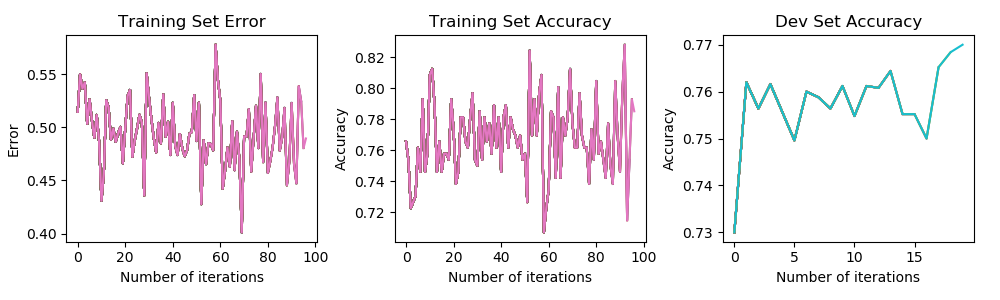

Training set error: 0.5146487557294809
Training set accuracy: 0.765625
Accuracy on dev set: 0.73
Training set error: 0.5264134994184511
Training set accuracy: 0.76171875
Accuracy on dev set: 0.762
Training set error: 0.4309506773786351
Training set accuracy: 0.80859375
Accuracy on dev set: 0.7564
Training set error: 0.4988600622038213
Training set accuracy: 0.74609375
Accuracy on dev set: 0.7616
Training set error: 0.49911215928723796
Training set accuracy: 0.7734375
Accuracy on dev set: 0.7556
Training set error: 0.4992543219084627
Training set accuracy: 0.765625
Accuracy on dev set: 0.7496
Training set error: 0.5282256760597461
Training set accuracy: 0.75
Accuracy on dev set: 0.76
Training set error: 0.4849651782050734
Training set accuracy: 0.77734375
Accuracy on dev set: 0.7588
Training set error: 0.5231532215170938
Training set accuracy: 0.74609375
Accuracy on dev set: 0.7564
Training set error: 0.4728611659401328
Training set accuracy: 0.7734375
Accuracy on dev set: 0.7612
Traini

In [23]:
parameters = train_model(X_train,Y_train,X_test[:2500],Y_test[:,:2500],num_epochs=1, batch_size=256,lambd=0,
                         learning_rate=3e-4,num_hidden_units=128,parameters=parameters)